In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import pingouin as pg
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import math
import seaborn as sns

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Antipredatory test

In [4]:
df_at = pd.read_excel('/Users/jialexu/Desktop/Project4SelectiveBreeding/experiment/AntipredatorTest/data/AntipredatorTest_summary.xlsx',
                     sheet_name=0, index_col=0)

In [5]:
def exoutliers(series):
    mean=series.mean()
    std=series.std()
    limit1=mean-1.95*std
    limit2=mean+1.95*std
    return series.loc[(series>limit1)&(series<limit2)]


In [6]:
df_sda = df_at.loc[df_at['Category']=='SDA']
df_vda = df_at.loc[df_at['Category']=='VDA']
result_list = []
mean_list=[]
sem_list=[]
for vc in ['CT', 'VC1', 'VC2']:
    SDA_Z1 = df_sda.loc[df_sda['Visual_cue']==vc]['zone1_adjusted_duration']
    SDA_Z1_pro = exoutliers(SDA_Z1)
    mean_list.append(SDA_Z1_pro.mean())
    sem_list.append(SDA_Z1_pro.sem())
    
    VDA_Z1 = df_vda.loc[df_vda['Visual_cue']==vc]['zone1_adjusted_duration']
    VDA_Z1_pro = exoutliers(VDA_Z1)
    mean_list.append(VDA_Z1_pro.mean())
    sem_list.append(VDA_Z1_pro.sem())
    
    result_list.append(pg.ttest(x = SDA_Z1_pro, y=VDA_Z1_pro))
df_result = pd.concat(result_list)
df_result.index = ['CT', 'VC1', 'VC2']
iterables = [['CT', 'VC1', 'VC2'], ['SDA', 'VDA']]
index = pd.MultiIndex.from_product(iterables, names=['visual_cue', 'category'])
df_summary_pro = pd.DataFrame({'mean':mean_list, 'sem':sem_list}, 
                              columns = ['mean', 'sem'], index = index)

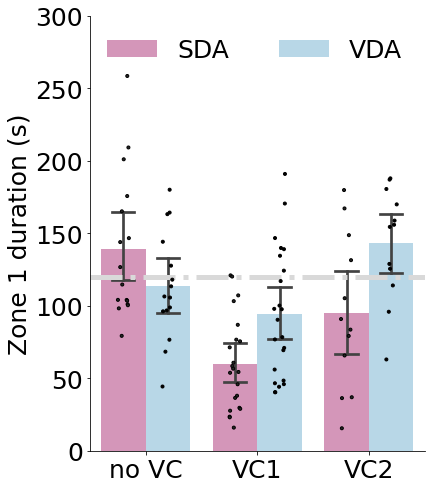

In [25]:
df = pd.concat((df_sda,df_vda))
df= df.sort_values(by='Visual_cue')
df = df.loc[df['Visual_cue'].isin(['CT', 'VC1', 'VC2'])]
f, ax = plt.subplots(1,1,figsize=(6,8))
color = {'SDA':'#DE8CBB', 'VDA':'#B0DAEF'}
sns.barplot(x = "Visual_cue",y = "zone1_adjusted_duration", hue = "Category",data = df, palette=color,ax=ax, capsize=0.2)

sns.stripplot(x="Visual_cue", y="zone1_adjusted_duration",hue = "Category",
              data=df, jitter=True,dodge=True, marker='o', color='black', 
              edgecolor='black',ax=ax, size=3,linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.axhline(120, linestyle= '-.', color = '#D9D9D9', linewidth= 5)
handles, labels = ax.get_legend_handles_labels()
ax.set_xticklabels(labels= ['no VC', 'VC1', 'VC2'], rotation=0, fontsize=25)
ax.set_yticks(np.arange(0,350,50))
ax.set_yticklabels(labels= np.arange(0,350, 50), rotation=0, fontsize=25)
ax.legend(handles[2:], labels[2:],loc = 'upper right', frameon=False, fontsize=25, ncol=2)
ax.set_xlabel("")
ax.set_ylabel("Zone 1 duration (s)",size=25)
ax.set_ylim(0,300)
plt.show()

In [10]:
df.loc[(df['Category']=='SDA')&(df['Visual_cue']=='CT')].shape

(16, 4)

In [11]:
df.loc[(df['Category']=='VDA')&(df['Visual_cue']=='CT')].shape

(15, 4)

In [12]:
df.loc[(df['Category']=='SDA')&(df['Visual_cue']=='VC1')].shape

(22, 4)

In [13]:
df.loc[(df['Category']=='SDA')&(df['Visual_cue']=='VC2')].shape

(12, 4)

In [16]:
df.loc[(df['Category']=='VDA')&(df['Visual_cue']=='VC1')].shape

(23, 4)

In [17]:
df.loc[(df['Category']=='VDA')&(df['Visual_cue']=='VC2')].shape

(12, 4)

In [5]:
df_summary_pro

mean        sem
visual_cue category                       
CT         SDA       131.616093  10.391006
           VDA       113.638490   9.695461
VC1        SDA        59.800559   6.852417
           VDA        89.820526   8.521655
VC2        SDA        95.076365  15.353641
           VDA       150.849450   9.307947

In [6]:
df_result

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
CT,1.264978,28.00000,two-sided,0.216306,"[-11.13, 47.09]",0.461905,0.628,0.230950
VC1,-2.745310,42.00000,two-sided,0.008859,"[-52.09, -7.95]",0.827742,5.397,0.764885
VC2,-3.106318,17.91021,two-sided,0.006122,"[-93.51, -18.04]",1.267709,8.232,0.825270


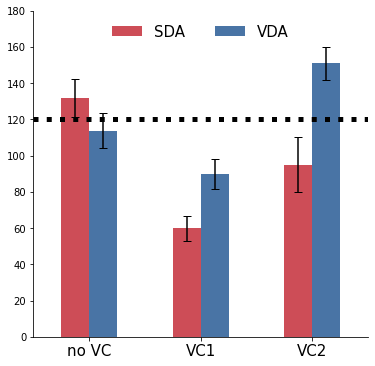

In [7]:
f, ax = plt.subplots(1,1, figsize=(6,6))
df_summary_pro_mean = pd.DataFrame(df_summary_pro['mean'].values.reshape(3,2), \
                                 index=['CT', 'VC1', 'VC2'],columns=['SDA','VDA'])
df_summary_pro_sem = pd.DataFrame(df_summary_pro['sem'].values.reshape(3,2), \
                                 index=['CT', 'VC1', 'VC2'],columns=['SDA','VDA'])

df_summary_pro_mean.plot(kind='bar', yerr=df_summary_pro_sem,capsize=4, ax=ax, color=['#cd4d57','#4974a5'])
ax.set_xticklabels(labels= ['no VC', 'VC1', 'VC2'], rotation=0, fontsize=15)
ax.set_ylim(0,180)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper center', frameon=False, fontsize=15, ncol=2)
ax.axhline(120, linestyle= 'dotted', color = 'black', linewidth= 5)
plt.show()

In [9]:
ttest_list = []
mean_list = []
sem_list = []
for df in [df_sda, df_vda]:
    for vc in ['VC1', 'VC2']:
        x = df.loc[df['Visual_cue']==vc]['zone1_adjusted_duration']
        x_pro = exoutliers(x)
        y = df.loc[df['Visual_cue']=='CT']['zone1_adjusted_duration']
        y_pro = exoutliers(y)
        
        if y_pro.mean() in mean_list:
            
            mean_list.append(x_pro.mean())
            sem_list.append(x_pro.sem())
            
        else:
            mean_list.append(y_pro.mean())
            sem_list.append(y_pro.sem())
            mean_list.append(x_pro.mean())
            sem_list.append(x_pro.sem())
        
        ttest_list.append(pg.ttest(x = x_pro, y=y_pro))
        
df_ttest = pd.concat(ttest_list)
index1 = pd.MultiIndex.from_product([['SDA', 'VDA'],['VC1_vs_CT', 'VC2_vs_CT']])
df_ttest.index = index1
df_ttest

T        dof alternative     p-val             CI95%  \
SDA VC1_vs_CT -5.769691  25.597110   two-sided  0.000005  [-97.42, -46.21]   
    VC2_vs_CT -1.970929  20.075216   two-sided  0.062677     [-75.2, 2.12]   
VDA VC1_vs_CT -1.845187  31.466439   two-sided  0.074440    [-50.13, 2.49]   
    VC2_vs_CT  2.768625  23.614989   two-sided  0.010772     [9.45, 64.97]   

                cohen-d      BF10     power  
SDA VC1_vs_CT  2.017058  8223.301  0.999950  
    VC2_vs_CT  0.787734     1.439  0.498286  
VDA VC1_vs_CT  0.610401     1.182  0.425895  
    VC2_vs_CT  1.065518     4.882  0.730924

In [16]:
index2 = pd.MultiIndex.from_product([['SDA','VDA'],['CT','VC1','VC2']])
df_summary_pro = pd.DataFrame({'mean':mean_list, 'sem':sem_list}, index=index2)
df_summary_pro 

mean        sem
SDA CT   131.616093  10.391006
    VC1   59.800559   6.852417
    VC2   95.076365  15.353641
VDA CT   113.638490   9.695461
    VC1   89.820526   8.521655
    VC2  150.849450   9.307947

In [24]:
df_mean = pd.DataFrame({'SDA':df_summary_pro.loc['SDA']['mean'], 'VDA':df_summary_pro.loc['VDA']['mean']}).transpose()

In [26]:
df_sem= pd.DataFrame({'SDA':df_summary_pro.loc['SDA']['sem'], 'VDA':df_summary_pro.loc['VDA']['sem']}).transpose()

/Users/jialexu/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


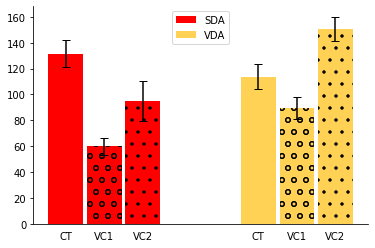

In [78]:
f, ax = plt.subplots(1,1)
ax.bar(x =[0.2,0.4,0.6], height=df_mean.iloc[0,:],yerr=df_sem.iloc[0,:],capsize=4,label='SDA',
       width=0.18, color=['#FF0000'],hatch=['','o','.'])
ax.bar(x =[1.2,1.4,1.6], height=df_mean.iloc[1,:],yerr=df_sem.iloc[1,:],capsize=4,label='VDA',
       width=0.18, color=['#FFD256'],hatch=['','o','.'])
ax.set_xticklabels(['','CT', 'VC1','VC2', '', '','CT', 'VC1','VC2'])
ax.tick_params(axis='x', bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper center')
plt.show()

In [26]:
workdir = '/Users/jialexu/Library/CloudStorage/Box-Box/UCSF/Research/Project4SelectiveBreeding/experiment/SDA_VDA_selection/data/'
df_Z3137_Z3138 = pd.read_excel(workdir+'Z3137_Z3138.xlsx', sheet_name=2, index_col=0)
f, ax = plt.subplots(1,1, figsize=(4,8), sharey=True)

sns.violinplot(data=df_Z3137_Z3138['Mean_LDCI'], ax=ax, color='#EBEBEB', inner='box')
sns.stripplot(data=df_Z3137_Z3138['Mean_LDCI'], jitter=True, zorder=1, color='#eecc16')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(-1.15, -0.05)
ax.tick_params(labelsize=15)
ax.set_yticks(np.arange(-1,0, 0.2))
ax.set_xticklabels('')
ax.set_xticks([])
ax.hlines(y=df_Z3137_Z3138['Mean_LDCI'].quantile(0.9),xmin=-0.4, xmax=0.4, linestyle='dashed', color='#4974a5')
ax.hlines(y=df_Z3137_Z3138['Mean_LDCI'].quantile(0.1),xmin=-0.4, xmax=0.4, linestyle='dashed', color='#cd4d57')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/jialexu/Library/CloudStorage/Box-Box/UCSF/Research/Project4SelectiveBreeding/experiment/SDA_VDA_selection/data/Z3137_Z3138.xlsx'